# Live Object Segmentation with OpenVINO

This notebook demonstrates live instance segmentation with OpenVINO, using the [EfficientNet-B1](https://docs.openvino.ai/latest/omz_models_model_instance_segmentation_person_0007.html#training-pipeline) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). Final part of this notebook shows live inference results from a webcam. Additionally, you can also upload a video file.

> **NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a server, the webcam will not work. However, you can still do inference on a video.

> **NOTE**: This notebook adapts the [tutorial](https://github.com/openvinotoolkit/openvino_notebooks/tree/main/notebooks/401-object-detection-webcam) from object detection to instance segmentation. This means quite a lot is modified from the original notebook, since the model isn't the same, the pre and postprocessing of each frame need to be adapted and implemented.

## Imports

In [1]:
import collections
import os
import sys
import time

import cv2
import numpy as np
from IPython import display
from openvino.runtime import Core

sys.path.append("./openvino_notebooks/notebooks/utils/")
import notebook_utils as utils

## The Model

### Download the Model

Use `omz_downloader`, which is a command-line tool from the `openvino-dev` package. It automatically creates a directory structure and downloads the selected model. This step is skipped if the model is already downloaded. The selected model comes from the public directory, which means it must be converted into OpenVINO Intermediate Representation (OpenVINO IR).

If you want to download another model (`ssdlite_mobilenet_v2`, `ssd_mobilenet_v1_coco`, `ssd_mobilenet_v2_coco`, `ssd_resnet50_v1_fpn_coco`, `ssd_mobilenet_v1_fpn_coco`) , replace the name of the model in the code below. 

> **NOTE**: Using a model outside the list can require different pre- and post-processing.

In [7]:
# A directory where the model will be downloaded.
base_model_dir = "model-segmentation"

model_segmentation = "instance-segmentation-person-0007"

In [8]:
download_command = f"omz_downloader " \
                   f"--name {model_segmentation} " \
                   f"--output_dir {base_model_dir} " \
                   f"--cache_dir {base_model_dir}"
! $download_command

'omz_downloader' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# The output path for the conversion.
converted_model_path = f"model-segmentation/intel/{model_segmentation}/FP16/{model_segmentation}.xml"

### Load the Model

Downloaded models are located in a fixed structure, which indicates a vendor (intel or public), the name of the model and a precision.

Only a few lines of code are required to run the model. First, initialize OpenVINO Runtime. Then, read the network architecture and model weights from the `.bin` and `.xml` files to compile for the desired device. If you choose `GPU` you need to wait for a while, as the startup time is much longer than in the case of `CPU`.

There is a possibility to allow OpenVINO to decide which hardware offers the best performance. In that case, just use `AUTO`. Remember that for most cases the best hardware is `GPU` (better performance, but longer startup time).

In [5]:
# Initialize OpenVINO Runtime.
ie_core = Core()
# Read the network and corresponding weights from a file.
model = ie_core.read_model(model=converted_model_path)
# Compile the model for CPU (you can choose manually CPU, GPU, MYRIAD etc.)
# or let the engine choose the best available device (AUTO).
compiled_model = ie_core.compile_model(model=model, device_name="CPU")

# Get the input and output nodes.
input_layer = compiled_model.input(0)
output_boxes = compiled_model.output(0)

# Get the input size.
height, width = list(input_layer.shape)[2:4]

RuntimeError: Check 'false' failed at C:\Jenkins\workspace\private-ci\ie\build-windows-vs2019\b\repos\openvino\src\inference\src\core.cpp:100:
Model file model-segmentation/intel/instance-segmentation-person-0007/FP16/instance-segmentation-person-0007.xml cannot be opened!


In [7]:
compiled_model.outputs

[<ConstOutput: names[boxes] shape[?,5] type: f32>,
 <ConstOutput: names[labels, 1973] shape[?] type: i64>,
 <ConstOutput: names[masks] shape[?,224,224] type: f32>]

In [27]:
compiled_model

<CompiledModel:
inputs[
<ConstOutput: names[image] shape[1,3,320,544] type: f32>
]
outputs[
<ConstOutput: names[boxes] shape[?,5] type: f32>,
<ConstOutput: names[labels, 1973] shape[?] type: i64>,
<ConstOutput: names[masks] shape[?,224,224] type: f32>
]>

## Processing

### Process Results

Functions adapted from:
- https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/common/python/visualizers/instance_segmentation.py
- https://github.com/openvinotoolkit/open_model_zoo/blob/5a3376f908abc0a1cae8838af6af89931644321d/demos/instance_segmentation_demo/python/instance_segmentation_demo.py#L31
- https://github.com/openvinotoolkit/open_model_zoo/blob/5a3376f908abc0a1cae8838af6af89931644321d/demos/common/python/openvino/model_zoo/model_api/models/instance_segmentation.py

In [9]:
import random
import colorsys

import numpy as np


class ColorPalette:
    def __init__(self, n, rng=None):
        if n == 0:
            raise ValueError('ColorPalette accepts only the positive number of colors')
        if rng is None:
            rng = random.Random(0xACE)  # nosec - disable B311:random check

        candidates_num = 100
        hsv_colors = [(1.0, 1.0, 1.0)]
        for _ in range(1, n):
            colors_candidates = [(rng.random(), rng.uniform(0.8, 1.0), rng.uniform(0.5, 1.0))
                                 for _ in range(candidates_num)]
            min_distances = [self.min_distance(hsv_colors, c) for c in colors_candidates]
            arg_max = np.argmax(min_distances)
            hsv_colors.append(colors_candidates[arg_max])

        self.palette = [self.hsv2rgb(*hsv) for hsv in hsv_colors]

    @staticmethod
    def dist(c1, c2):
        dh = min(abs(c1[0] - c2[0]), 1 - abs(c1[0] - c2[0])) * 2
        ds = abs(c1[1] - c2[1])
        dv = abs(c1[2] - c2[2])
        return dh * dh + ds * ds + dv * dv

    @classmethod
    def min_distance(cls, colors_set, color_candidate):
        distances = [cls.dist(o, color_candidate) for o in colors_set]
        return np.min(distances)

    @staticmethod
    def hsv2rgb(h, s, v):
        return tuple(round(c * 255) for c in colorsys.hsv_to_rgb(h, s, v))

    def __getitem__(self, n):
        return self.palette[n % len(self.palette)]

    def __len__(self):
        return len(self.palette)

In [18]:
class InstanceSegmentationVisualizer:
    def __init__(self, labels=None, show_boxes=False, show_scores=False):
        colors_num = len(labels) if labels else 80
        self.labels = labels
        self.palette = ColorPalette(colors_num)
        self.show_boxes = show_boxes
        self.show_scores = show_scores

    def __call__(self, image, boxes, classes, scores, masks=None, ids=None, texts=None):
        result = image.copy()

        if masks is not None:
            result = self.overlay_masks(result, masks, ids)
        if self.show_boxes:
            result = self.overlay_boxes(result, boxes, classes)

        result = self.overlay_labels(result, boxes, classes, scores, texts)
        return result

    def overlay_masks(self, image, masks, ids=None):
        segments_image = image.copy()
        aggregated_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        aggregated_colored_mask = np.zeros(image.shape, dtype=np.uint8)
        all_contours = []

        for i, mask in enumerate(masks):
            mask = mask.astype(np.uint8)
            contours = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
            if contours:
                all_contours.append(contours[0])

            mask_color = self.palette[i if ids is None else ids[i]]
            cv2.bitwise_or(aggregated_mask, mask, dst=aggregated_mask)
            cv2.bitwise_or(aggregated_colored_mask, mask_color, dst=aggregated_colored_mask, mask=mask)

        # Fill the area occupied by all instances with a colored instances mask image
        cv2.bitwise_and(segments_image, (0, 0, 0), dst=segments_image, mask=aggregated_mask)
        cv2.bitwise_or(segments_image, aggregated_colored_mask, dst=segments_image, mask=aggregated_mask)

        cv2.addWeighted(image, 0.5, segments_image, 0.5, 0, dst=image)
        cv2.drawContours(image, all_contours, -1, (0, 0, 0))
        return image

    def overlay_boxes(self, image, boxes, classes):
        for box, class_id in zip(boxes, classes):
            color = self.palette[class_id]
            box = box.astype(int)
            top_left, bottom_right = box[:2], box[2:]
            image = cv2.rectangle(image, top_left, bottom_right, color, 2)
        return image

    def overlay_labels(self, image, boxes, classes, scores, texts=None):
        if texts:
            labels = texts
        elif self.labels:
            labels = (self.labels[class_id] for class_id in classes)
        else:
            raise RuntimeError('InstanceSegmentationVisualizer must contain either labels or texts to display')
        template = '{}: {:.2f}' if self.show_scores else '{}'

        for box, score, label in zip(boxes, scores, labels):
            text = template.format(label, score)
            textsize = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
            position = ((box[:2] + box[2:] - textsize) / 2).astype(np.int32)
            cv2.putText(image, text, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        return image

In [19]:
# https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
classes = [
    "person", "background", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "street sign", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant",
    "bear", "zebra", "giraffe", "hat", "backpack", "umbrella", "shoe", "eye glasses",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "plate", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "mirror", "dining table", "window", "desk", "toilet",
    "door", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "blender", "book", "clock", "vase", "scissors",
    "teddy bear", "hair drier", "toothbrush", "hair brush"
]

def _expand_box(box, scale):
        w_half = (box[2] - box[0]) * .5
        h_half = (box[3] - box[1]) * .5
        x_c = (box[2] + box[0]) * .5
        y_c = (box[3] + box[1]) * .5
        w_half *= scale
        h_half *= scale
        box_exp = np.zeros(box.shape)
        box_exp[0] = x_c - w_half
        box_exp[2] = x_c + w_half
        box_exp[1] = y_c - h_half
        box_exp[3] = y_c + h_half
        return box_exp
    
def postprocess_mask(box, raw_cls_mask, im_h, im_w):
    # Add zero border to prevent upsampling artifacts on segment borders.
    raw_cls_mask = np.pad(raw_cls_mask, ((1, 1), (1, 1)), 'constant', constant_values=0)
    extended_box = _expand_box(box, raw_cls_mask.shape[0] / (raw_cls_mask.shape[0] - 2.0)).astype(int)
    w, h = np.maximum(extended_box[2:] - extended_box[:2] + 1, 1)
    x0, y0 = np.clip(extended_box[:2], a_min=0, a_max=[im_w, im_h])
    x1, y1 = np.clip(extended_box[2:] + 1, a_min=0, a_max=[im_w, im_h])

    raw_cls_mask = cv2.resize(raw_cls_mask.astype(np.float32), (w, h)) > 0.5
    mask = raw_cls_mask.astype(np.uint8)
    # Put an object mask in an image mask.
    im_mask = np.zeros((im_h, im_w), dtype=np.uint8)
    im_mask[y0:y1, x0:x1] = mask[(y0 - extended_box[1]):(y1 - extended_box[1]),
                                (x0 - extended_box[0]):(x1 - extended_box[0])]
    return im_mask

def process_results(frame, input_img, results, thresh=0.6):
    # The size of the original frame.
    h, w = frame.shape[:2]
    # size of input image
    im_h, im_w = input_img.shape[2:]
    #scales
    scale_x = im_w / w
    scale_y = im_h / h
    
    # Extract results from list
    results_boxes = results[0]
    results_labels = results[1]
    results_masks = results[2]
    #keep only objects with confidence score > 0.2
    mask = results_boxes[:, -1] > 0.2
    results_boxes = results_boxes[mask]
    results_labels = results_labels[mask]
    results_masks = results_masks[mask]
    
    boxes = []
    labels = []
    scores = []
    masks = []
    
    for i, (top_left_x, top_left_y, bottom_right_x, bottom_right_y, score) in enumerate(results_boxes):
        box = np.array([top_left_x/scale_x,
                        top_left_y/scale_y,
                        bottom_right_x/scale_x,
                        bottom_right_y/scale_y]).astype(int)
        boxes.append(box)
        labels.append(int(results_labels[i]))
        scores.append(float(score))
        masks.append(postprocess_mask(box, results_masks[i], h, w))

    return labels, scores, boxes, masks

### Main Processing Function

Run object detection on the specified source. Either a webcam or a video file.

In [20]:
# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        visualizer = InstanceSegmentationVisualizer(classes, True, True)
        
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Resize the image and change dims to fit neural network input.
            input_img = cv2.resize(
                src=frame, dsize=(width, height), interpolation=cv2.INTER_AREA
            )
            # Create a batch of images (size = 1).
            input_img = input_img[np.newaxis, ...]
            input_img = np.moveaxis(input_img, -1, 1)

            # Measure processing time.

            start_time = time.time()
            # Get the results.
            results = list(compiled_model([input_img]).values())
            stop_time = time.time()
            # Get network outputs
            labels, scores, boxes, masks = process_results(frame=frame, input_img=input_img, results=results)
            # visualize
            frame = visualizer(frame, boxes, labels, scores, masks, None)
            
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

## Run

### Run Live Object Detection


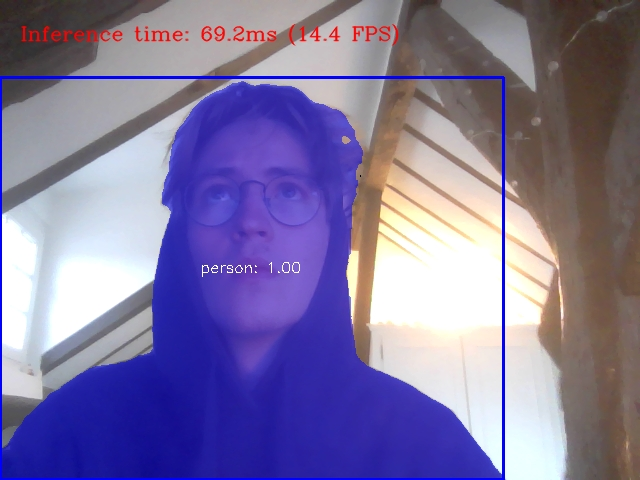

Interrupted


In [21]:
run_object_detection(source=0, flip=True, use_popup=False)

### Run Object Detection on a Video File

If you do not have a webcam, you can still run this demo with a video file. Any [format supported by OpenCV](https://docs.opencv.org/4.5.1/dd/d43/tutorial_py_video_display.html) will work.

In [ ]:
video_file = "../data/video/Coco Walking in Berkeley.mp4"

run_object_detection(source=video_file, flip=False, use_popup=False)

## References

1. [SSDLite MobileNetV2](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/ssdlite_mobilenet_v2)
2. [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/)
3. [Non-Maximum Suppression](https://paperswithcode.com/method/non-maximum-suppression)